Source: https://github.com/shankal17/NNs-for-Differential-Equations

In [1]:
!git clone https://github.com/shankal17/NNs-for-Differential-Equations.git
!cp -a /content/NNs-for-Differential-Equations/scripts/. /content/

Cloning into 'NNs-for-Differential-Equations'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 48 (delta 16), reused 20 (delta 4), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [2]:
# Import necessary resources
import os
import sys
import inspect
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 14]


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, os.path.join(parentdir, 'scripts'))

import models as m
import utils

# First-Order ODEs

Note that a first-order ODE must be able to be written in the form 

\begin{align}
\frac{d}{dx}\Psi + p(x)\Psi = g(x)
\end{align}

Where both $p(x)$ and $g(x)$ are continuous functions.

## Example I
Consider the first-order ODE:
\begin{align}
\frac{d}{dx}\Psi + (x+\frac{1 + 3 x^2}{1 + x+ x^3})\Psi = x^3 + 2x +x^2\frac{1 + 3x^2}{1 + x + x^3},\quad \Psi(0) = 1 \quad and \quad x\in [0,1]
\end{align}
Solve for $\Psi(x)$


### Step 1: Define DE and Initial Condition

In [3]:
# Define Differential Equation
# Initial condition
f_0 = 1

# differential equation
def g(x):
    return x**3 + 2*x + (x**2)*((1+3*x**2)/(1+x+x**3))

def p(x):
    return x + ((1+3*(x**2))/(1+x+x**3))

### Step 2: Train the NN

In [4]:
learning_rate = 0.003
epochs = 1000
display_step = 100

# Define NN
neural_network = m.MLP()

# Create optimizer
optimizer = optim.Adam(neural_network.parameters(), lr=learning_rate)

# Run the training steps
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Compute the loss
    loss = utils.first_order_loss_with_ic(neural_network, p, g, f_0)
    
    # Backpropagate
    loss.backward()
    
    # Adjust model parameters accordingly
    optimizer.step()
    
    if epoch % display_step == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

epoch: 0, loss: 9.16983413696289
epoch: 100, loss: 2.1148223876953125
epoch: 200, loss: 0.0923054963350296
epoch: 300, loss: 0.06916677206754684
epoch: 400, loss: 0.05735695734620094
epoch: 500, loss: 0.05375770479440689
epoch: 600, loss: 0.04617598280310631
epoch: 700, loss: 0.04035697504878044
epoch: 800, loss: 0.0326937660574913
epoch: 900, loss: 0.030835501849651337


### Step 3: Visualize Result

Solving the DE by hand gives the exact result of $\Psi_a(x) = \frac{e^{\frac{-x^2}{2}}}{1+x+x^3} + x^2$. We will plot this against the trained trial solution.

Text(0, 0.5, 'Error')

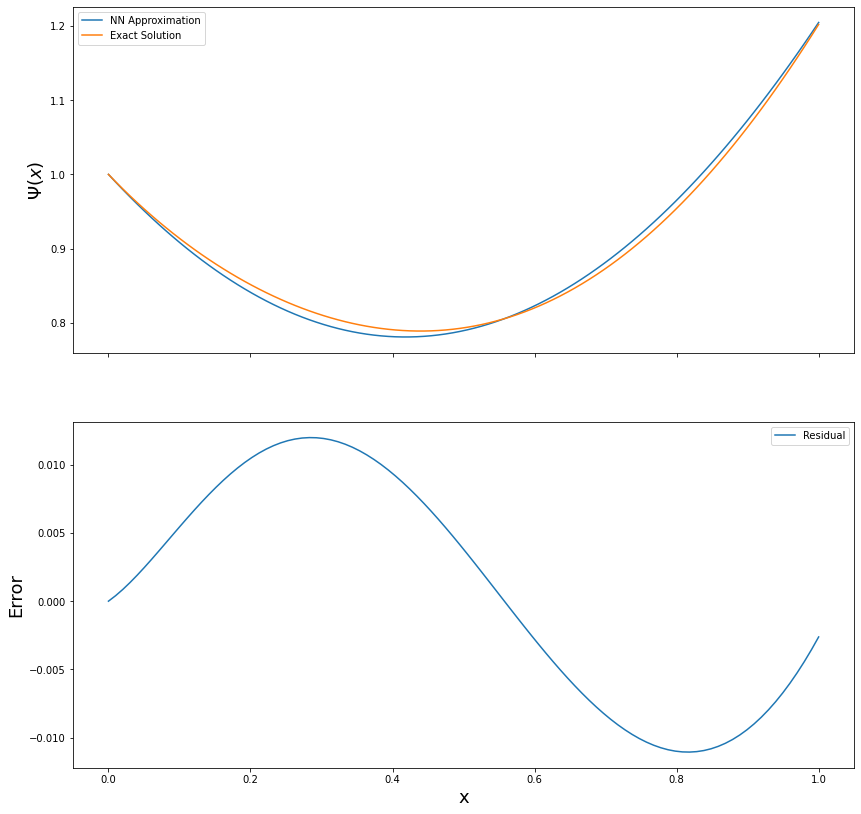

In [5]:
# Calculate 
x = torch.linspace(0, 1, 100, requires_grad=True).unsqueeze(1)
y_approx = (f_0 + x * neural_network(x)).squeeze(0).detach().numpy().transpose()[0]
y_exact = ((torch.exp(-(x**2)/2)/(1+x+x**3))+x**2).squeeze(0).detach().numpy().transpose()[0]
x = x.squeeze(0).detach().numpy().transpose()[0]


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# Plot the analytical solution with the approximation
ax1.plot(x, y_approx, label='NN Approximation')
ax1.plot(x, y_exact, label='Exact Solution')
ax1.legend()

# Plot the residual
ax2.plot(x, y_exact-y_approx, label='Residual')
ax2.legend()

ax2.set_xlabel('x', fontsize=18)
ax1.set_ylabel("$\Psi(x)$", fontsize=18)
ax2.set_ylabel("Error", fontsize=18)

## Example II: More Complicated
Consider the first-order ODE:
\begin{align}
\frac{d}{dx}\Psi + \frac{1}{5}\Psi = e^{-\frac{x}{5}}cos(x),\quad \Psi(0) = 0 \quad and \quad x\in [0,10]
\end{align}
Solve for $\Psi(x)$

### Step 1: Define DE and Initial Condition

In [6]:
# Define sample problem
# Initial condition
f_0 = 0

# differential equation
def g(x):
    return torch.exp(-x/5)*torch.cos(x)

def p(x):
    return 1/5

# Domain
domain = (0, 6)

### Step 2: Train the NN

In [7]:
learning_rate = 0.003
epochs = 2000
display_step = 500

# Define NN
neural_network = m.MLP()

# Create optimizer
optimizer = optim.Adam(neural_network.parameters(), lr=learning_rate)

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = utils.first_order_loss_with_ic(neural_network, p, g, f_0, domain[0], domain[1], 20)
    loss.backward()
    optimizer.step()
    # print(loss.item())
    if epoch % display_step == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

epoch: 0, loss: 10.343633651733398
epoch: 500, loss: 0.039687469601631165
epoch: 1000, loss: 0.020201105624437332
epoch: 1500, loss: 0.01537273358553648


### Step 3: Visualize Result

Solving the DE by hand gives the exact result of $\Psi_a(x) = e^{-\frac{x}{5}}sin(x)$. We will plot this against the trained trial solution.

Text(0, 0.5, 'Error')

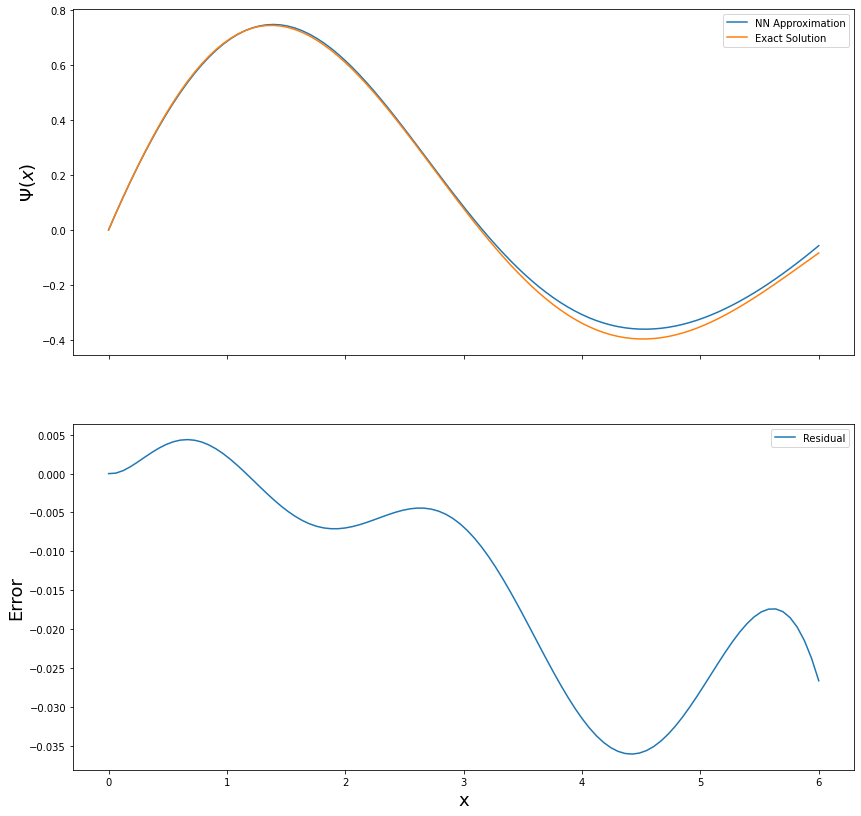

In [8]:
x = torch.linspace(domain[0], domain[1], 100, requires_grad=True).unsqueeze(1)
y_approx = (f_0 + x * neural_network(x)).squeeze(0).detach().numpy().transpose()[0]
y_exact = (torch.exp(-x/5)*torch.sin(x)).squeeze(0).detach().numpy().transpose()[0]
x = x.squeeze(0).detach().numpy().transpose()[0]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(x, y_approx, label='NN Approximation')
ax1.plot(x, y_exact, label='Exact Solution')
ax1.legend()
ax2.plot(x, y_exact-y_approx, label='Residual')
ax2.legend()

ax2.set_xlabel('x', fontsize=18)
ax1.set_ylabel("$\Psi(x)$", fontsize=18)
ax2.set_ylabel("Error", fontsize=18)

# Second-Order ODEs

Note that a second-order ODE must be able to be written in the form 

\begin{align}
\frac{d^2}{dx^2}\Psi + a(x)\frac{d}{dx}\Psi + b(x)\Psi = g(x)
\end{align}

Where $a(x)$, $b(x)$, and $g(x)$ are continuous functions.

## Example III
The method described will be used to approximate the solution $\Psi(x)$ to the following second-order ODE:

\begin{align}
\frac{d^2}{dx^2}\Psi + \frac{1}{5}\frac{d}{dx}\Psi + \Psi= -\frac{1}{5}e^{-\frac{x}{5}}cos(x), \quad \Psi(0) = 0, \; \frac{d}{dx}\Psi(0)=1 \quad over \quad x\in [0,2]
\end{align}

In [9]:
# Define sample problem
# Initial condition
f_0 = 0
f_prime_0 = 1

# differential equation
def g(x):
    result = -(1.0/5.0)*torch.ones_like(x, requires_grad=True)*torch.exp(-x/5.0)*torch.cos(x)
#     print(result.requires_grad)
    return result

def a(x):
    result =(1.0/5.0)*torch.ones_like(x, requires_grad=True)
#     print(result.requires_grad)
    return result

def b(x):
    return torch.ones_like(x, requires_grad=True)

domain = (0, 2)

In [10]:
learning_rate = 0.0005
epochs = 2000
display_step = 100

# Define NN
neural_network = m.MLP()

# Create optimizer
optimizer = optim.Adam(neural_network.parameters(), lr=learning_rate)

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = utils.second_order_loss_with_ic(neural_network, a, b, g, f_0, f_prime_0, domain[0], domain[1], 9)
    loss.backward()
    optimizer.step()
    
    if epoch % display_step == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

epoch: 0, loss: 46.964969635009766
epoch: 100, loss: 0.11258266121149063
epoch: 200, loss: 0.32089951634407043
epoch: 300, loss: 0.0934503898024559
epoch: 400, loss: 0.2558481693267822
epoch: 500, loss: 0.12921038269996643
epoch: 600, loss: 0.10403524339199066
epoch: 700, loss: 0.09326907247304916
epoch: 800, loss: 0.1365494579076767
epoch: 900, loss: 0.09588111191987991
epoch: 1000, loss: 0.19612807035446167
epoch: 1100, loss: 0.12996715307235718
epoch: 1200, loss: 0.22211650013923645
epoch: 1300, loss: 0.09438668191432953
epoch: 1400, loss: 0.05040612071752548
epoch: 1500, loss: 0.412593811750412
epoch: 1600, loss: 0.32421761751174927
epoch: 1700, loss: 0.4172455966472626
epoch: 1800, loss: 0.34156766533851624
epoch: 1900, loss: 0.45065057277679443


Text(0, 0.5, 'Error')

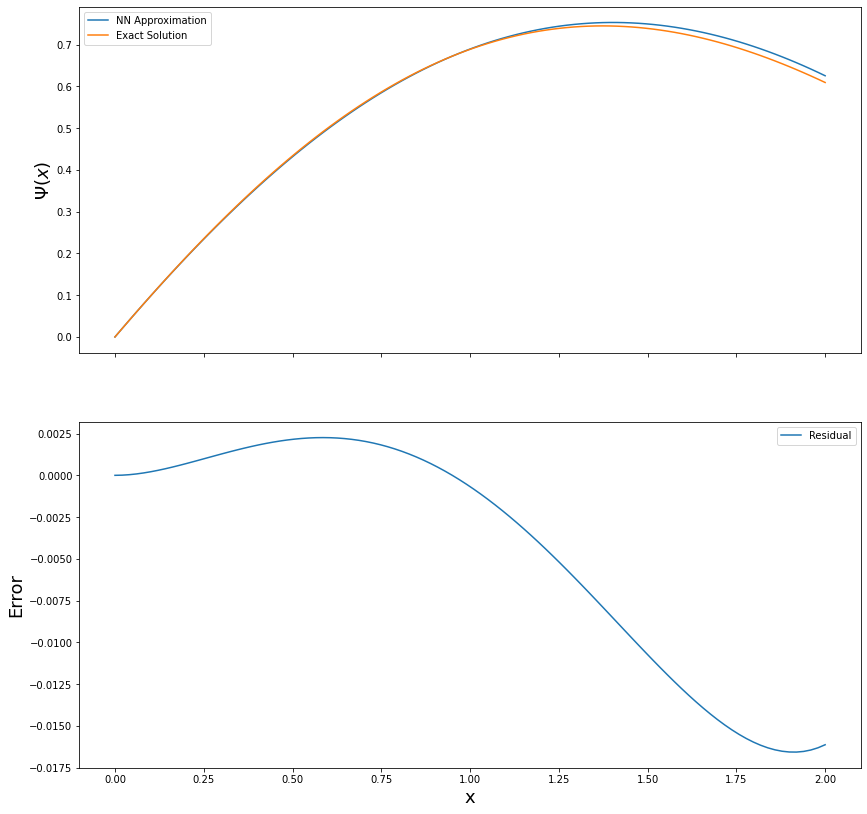

In [11]:
x = torch.linspace(domain[0], domain[1], 100, requires_grad=True).unsqueeze(1)
y_approx = (f_0 + x*f_prime_0 + x**2 * neural_network(x)).squeeze(0).detach().numpy().transpose()[0]
y_exact = (torch.exp(-x/5)*torch.sin(x)).squeeze(0).detach().numpy().transpose()[0]
x = x.squeeze(0).detach().numpy().transpose()[0]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(x, y_approx, label='NN Approximation')
ax1.plot(x, y_exact, label='Exact Solution')
ax1.legend()
ax2.plot(x, y_exact-y_approx, label='Residual')
ax2.legend()

ax2.set_xlabel('x', fontsize=18)
ax1.set_ylabel("$\Psi(x)$", fontsize=18)
ax2.set_ylabel("Error", fontsize=18)